# Pose-Based Spatiotemporal Action Classification in Combat Sports

This work develops a pipeline for classifying boxing actions from monocular video. 2D skeletal keypoints are extracted from video frames to construct pose sequences, which are then used to train a lightweight temporal classifier to distinguish between fundamental punch types. The approach leverages transfer learning from large-scale pose estimation models to minimize data requirements while maintaining classification accuracy suitable for technique analysis.

The underlying motivation stems from a gap between what video analysis could provide and what it currently does. A boxer preparing for a fight studies footage of their opponent, but this study remains qualitative: they watch, they notice patterns, and they form impressions. The central question is whether these impressions can be grounded in quantitative measurement. If an opponent telegraphs a right hook with a shoulder dip, the signature should be detectable automatically. If they favor body shots in the third round, that tendency can be surfaced from the data.

Predicting what an opponent will do next is not attempted, nor is the estimation of the force behind a punch. Both tasks require information that monocular video cannot provide. What video *can* provide is the trajectory of limbs through space and time. From these trajectories, a vocabulary of actions and a statistical profile of their usage can be extracted.

## 1. The Recognition Problem

Combat sports analysis requires understanding three things about any action: what it was, when it occurred, and how it was executed. Traditional approaches split along a familiar tradeoff. Manual annotation by domain experts produces accurate labels but scales poorly. Sensor-based motion capture produces rich data but demands specialized equipment that fighters cannot wear in competition. Video-based recognition scales naturally since every fight is recorded, but historically this approach sacrificed accuracy for accessibility.

Recent advances in pose estimation change this calculus. Models trained on millions of images can now extract skeletal representations from standard video with accuracy approaching that of marker-based systems. This reduces the problem from high-dimensional pixel space, where a single frame contains hundreds of thousands of values, to low-dimensional pose space, where the same frame reduces to perhaps fifty numbers describing joint positions. The question becomes whether this compressed representation preserves enough information to distinguish a jab from a cross, a hook from an uppercut.

The answer from the literature is encouraging. Skeleton-based methods achieve comparable accuracy to RGB-based methods on action recognition benchmarks while requiring significantly less training data and generalizing better across visual domains [4]. A model trained on poses from one gym transfers to another gym more readily than a model trained on raw pixels, because pose representations abstract away the irrelevant variation in lighting, clothing, and background that pixel representations entangle with the relevant variation in body movement.

The foundation for such a system is established here: video quality thresholds for reliable pose extraction, a preprocessing pipeline from raw footage to normalized pose sequences, a taxonomy of boxing actions grounded in biomechanical distinctions, and a baseline classification architecture suitable for training on limited labeled data.

## 2. Related Work

The technical lineage of this work traces through two parallel developments: pose estimation and action recognition.

On the pose estimation side, the critical breakthrough came from Cao et al. [1] with OpenPose, which demonstrated real-time multi-person pose estimation using part affinity fields to associate detected joints with individuals. Subsequent work from Xu et al. [3] showed that Vision Transformers could achieve superior accuracy on pose estimation benchmarks, with ViTPose establishing new state-of-the-art results on COCO while maintaining reasonable inference speed.

On the action recognition side, Yan et al. [2] introduced spatial-temporal graph convolutional networks (ST-GCN), which model the skeleton as a graph where joints are nodes and bones are edges. Graph convolutions exploit this structure to learn features that respect anatomical constraints. Liu et al. [5] extended this approach with multi-scale graph convolutions that capture both local joint interactions and global body configurations.

The connection between these threads was clarified by Duan et al. [4], who systematically compared RGB-based and skeleton-based approaches on multiple benchmarks. Their finding that skeleton-based methods match RGB-based methods while requiring less data and compute justifies the choice to operate in pose space rather than pixel space.

MediaPipe [6] provides a practical bridge from research to application. Google's framework offers pose estimation that runs on CPU at interactive rates, enabling rapid prototyping without GPU infrastructure. While less accurate than ViTPose on benchmarks, MediaPipe's accessibility makes it valuable for initial development before transitioning to more capable models.

| Work | Approach | Contribution |
|------|----------|--------------|
| Cao et al., 2019 [1] | OpenPose | Multi-person 2D pose via part affinity fields |
| Yan et al., 2018 [2] | ST-GCN | Graph convolutions on skeleton sequences |
| Xu et al., 2022 [3] | ViTPose | Vision Transformer for pose estimation |
| Duan et al., 2022 [4] | PoseConv3D | Systematic comparison of RGB vs skeleton methods |
| Liu et al., 2020 [5] | MS-G3D | Multi-scale temporal graph convolutions |
| Lugaresi et al., 2019 [6] | MediaPipe | Production framework for perception pipelines |

## 3. Video Quality Requirements

Pose estimation accuracy degrades predictably with video quality, and the degradation is not graceful. Below certain thresholds, the model does not produce slightly worse estimates; it produces nonsense. Minimum requirements must therefore be established to reject videos that fail to meet them before wasting computation on doomed inference.

The critical parameters are frame rate, resolution, and bitrate. Frame rate matters because a fast jab spans roughly 100 milliseconds from initiation to full extension. At 30 frames per second, this motion occupies three frames, barely enough to capture the trajectory. At 24 fps there are two frames—the minimum for any temporal reasoning. Below 24 fps, punches become discontinuous jumps that confound both pose estimation and action classification.

Resolution matters because pose estimation models were trained on crops of approximately 256 by 256 pixels. When the input resolution falls too low, distal joints like wrists and ankles become ambiguous blobs rather than localizable points. 480p is set as the minimum, which provides adequate detail when the subject occupies a reasonable fraction of the frame.

Bitrate matters because video compression introduces blocking artifacts, and these artifacts concentrate precisely where clarity is needed: on fast-moving limbs during punches. Heavy compression at 500 kbps creates visible blocks on the fist during extension, corrupting the keypoint estimates. At least 1 Mbps is required, though higher is better.

Duration establishes a minimum sample for statistical analysis. A 30-second clip contains perhaps 10-20 individual punches depending on activity level, enough to observe tendencies but not enough to estimate distributions with confidence. This threshold ensures that analysis is not attempted on clips too short to support meaningful conclusions.

In [1]:
import cv2
from dataclasses import dataclass
from typing import Optional
from pathlib import Path
import os

@dataclass
class VideoQualityReport:
    """Encapsulates the results of video quality validation."""
    filepath: str
    width: int
    height: int
    fps: float
    duration_seconds: float
    bitrate_kbps: Optional[float]
    codec: str
    passes_minimum: bool
    rejection_reasons: list

# These thresholds derive from the analysis in Section 3. Videos failing any
# threshold will be rejected before pose estimation to avoid wasted computation.
MIN_FPS = 24.0
MIN_WIDTH = 640
MIN_HEIGHT = 480
MIN_BITRATE_KBPS = 1000
MIN_DURATION_SECONDS = 30.0

# OpenCV codec fourcc to human-readable name mapping
FOURCC_CODECS = {
    'avc1': 'h264',
    'h264': 'h264',
    'hvc1': 'hevc',
    'hevc': 'hevc',
    'mp4v': 'mpeg4',
    'xvid': 'xvid',
    'mjpg': 'mjpeg',
    'vp80': 'vp8',
    'vp90': 'vp9',
    'av01': 'av1',
}


def extract_video_metadata_opencv(filepath: str) -> dict:
    """
    Extracts video stream metadata using OpenCV. This approach requires no
    external system dependencies like ffmpeg, making the code portable across
    different environments without additional installation steps.
    """
    cap = cv2.VideoCapture(filepath)
    
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video file: {filepath}")
    
    try:
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Duration calculated from frame count and fps
        duration = frame_count / fps if fps > 0 else 0
        
        # Extract codec fourcc code
        fourcc_int = int(cap.get(cv2.CAP_PROP_FOURCC))
        fourcc_str = ''.join([chr((fourcc_int >> 8 * i) & 0xFF) for i in range(4)]).lower().strip()
        codec = FOURCC_CODECS.get(fourcc_str, fourcc_str if fourcc_str else 'unknown')
        
        # Estimate bitrate from file size (OpenCV doesn't provide bitrate directly)
        bitrate_kbps = None
        if os.path.exists(filepath) and duration > 0:
            file_size_bytes = os.path.getsize(filepath)
            bitrate_kbps = (file_size_bytes * 8) / (duration * 1000)
        
        return {
            'width': width,
            'height': height,
            'fps': fps,
            'frame_count': frame_count,
            'duration': duration,
            'codec': codec,
            'bitrate_kbps': bitrate_kbps,
        }
    finally:
        cap.release()


def validate_video_quality(filepath: str) -> VideoQualityReport:
    """Validates a video against minimum quality thresholds for pose estimation."""
    metadata = extract_video_metadata_opencv(filepath)
    
    width = metadata['width']
    height = metadata['height']
    fps = metadata['fps']
    duration = metadata['duration']
    bitrate_kbps = metadata['bitrate_kbps']
    codec = metadata['codec']
    
    rejection_reasons = []
    
    if fps < MIN_FPS:
        rejection_reasons.append(f"Frame rate {fps:.2f} fps falls below {MIN_FPS} fps minimum")
    
    if width < MIN_WIDTH or height < MIN_HEIGHT:
        rejection_reasons.append(f"Resolution {width}×{height} falls below {MIN_WIDTH}×{MIN_HEIGHT} minimum")
    
    if bitrate_kbps is not None and bitrate_kbps < MIN_BITRATE_KBPS:
        rejection_reasons.append(f"Bitrate {bitrate_kbps:.0f} kbps falls below {MIN_BITRATE_KBPS} kbps minimum")
    
    if duration < MIN_DURATION_SECONDS:
        rejection_reasons.append(f"Duration {duration:.1f}s falls below {MIN_DURATION_SECONDS}s minimum")
    
    return VideoQualityReport(
        filepath=filepath,
        width=width,
        height=height,
        fps=fps,
        duration_seconds=duration,
        bitrate_kbps=bitrate_kbps,
        codec=codec,
        passes_minimum=len(rejection_reasons) == 0,
        rejection_reasons=rejection_reasons
    )


def print_quality_report(report: VideoQualityReport) -> None:
    """Displays video quality validation results in a readable format."""
    print(f"\n{'='*60}")
    print(f"Video Quality Report for {Path(report.filepath).name}")
    print(f"{'='*60}")
    print(f"Resolution:  {report.width} × {report.height}")
    print(f"Frame rate:  {report.fps:.2f} fps")
    print(f"Duration:    {report.duration_seconds:.1f} seconds")
    print(f"Bitrate:     {report.bitrate_kbps:.0f} kbps" if report.bitrate_kbps else "Bitrate:     unavailable")
    print(f"Codec:       {report.codec}")
    print(f"{'='*60}")
    
    if report.passes_minimum:
        print("✓ Video meets minimum quality requirements for pose estimation")
    else:
        print("✗ Video fails minimum quality requirements")
        for reason in report.rejection_reasons:
            print(f"  • {reason}")
    print()

## 4. Action Taxonomy

Boxing actions decompose along three biomechanical axes: which hand initiates the punch, what trajectory the fist follows, and what height it targets. The hand distinction separates lead punches thrown with the front hand from rear punches thrown with the back hand. Lead punches travel less distance and arrive faster but carry less power; rear punches rotate the hips and shoulders to generate force but telegraph their intent through that rotation.

The trajectory distinction separates straight punches from hooks from uppercuts. Straight punches extend the arm directly toward the target with the elbow reaching near-full extension at impact. Hooks swing the arm in a lateral arc, keeping the elbow bent at roughly 90 degrees throughout. Uppercuts rise vertically with the elbow below the shoulder, scooping upward into the target.

The target distinction separates punches aimed at the head from those aimed at the body. This matters tactically because head shots score differently than body shots in competition and require different defensive responses.

Combining these axes yields twelve distinct punch types. We add an overhand, which follows a looping arc distinct from the standard hook, plus categories for defensive movement and idle stance. The resulting thirteen-class taxonomy covers the vocabulary of boxing actions we aim to recognize.

Each class produces distinct signatures in pose space. Jabs and crosses differ in which shoulder leads forward, since rear punches require hip rotation to generate power. Straights and hooks differ in elbow angle at extension. Hooks and uppercuts differ in elbow position relative to the shoulder. Head and body shots differ in the endpoint height of the trajectory. These distinctions are detectable from 2D pose sequences given sufficient temporal resolution, which is precisely what our quality thresholds ensure.

In [2]:
from enum import IntEnum
from typing import Dict, List

class BoxingAction(IntEnum):
    """
    Thirteen-class taxonomy for boxing actions. The naming convention follows
    the pattern HAND_TRAJECTORY_TARGET where applicable. Uppercuts do not
    distinguish head from body targets because their rising trajectory makes
    the distinction depend more on distance than intent.
    """
    JAB_HEAD = 0
    JAB_BODY = 1
    CROSS_HEAD = 2
    CROSS_BODY = 3
    LEAD_HOOK_HEAD = 4
    LEAD_HOOK_BODY = 5
    REAR_HOOK_HEAD = 6
    REAR_HOOK_BODY = 7
    LEAD_UPPERCUT = 8
    REAR_UPPERCUT = 9
    OVERHAND = 10
    DEFENSIVE = 11
    IDLE = 12


ACTION_LABELS: Dict[int, str] = {
    0: "Jab (Head)",
    1: "Jab (Body)",
    2: "Cross (Head)",
    3: "Cross (Body)",
    4: "Lead Hook (Head)",
    5: "Lead Hook (Body)",
    6: "Rear Hook (Head)",
    7: "Rear Hook (Body)",
    8: "Lead Uppercut",
    9: "Rear Uppercut",
    10: "Overhand",
    11: "Defensive Movement",
    12: "Idle/Stance",
}


# Keyboard shortcuts for the labeling interface. The boxing expert will watch
# video clips and press these keys to assign labels rapidly.
LABEL_HOTKEYS: Dict[str, int] = {
    '1': BoxingAction.JAB_HEAD,
    '2': BoxingAction.JAB_BODY,
    '3': BoxingAction.CROSS_HEAD,
    '4': BoxingAction.CROSS_BODY,
    '5': BoxingAction.LEAD_HOOK_HEAD,
    '6': BoxingAction.LEAD_HOOK_BODY,
    '7': BoxingAction.REAR_HOOK_HEAD,
    '8': BoxingAction.REAR_HOOK_BODY,
    '9': BoxingAction.LEAD_UPPERCUT,
    '0': BoxingAction.REAR_UPPERCUT,
    'o': BoxingAction.OVERHAND,
    'd': BoxingAction.DEFENSIVE,
    'i': BoxingAction.IDLE,
}


def get_action_hierarchy() -> Dict[str, List[BoxingAction]]:
    """Groups actions by trajectory type for hierarchical analysis and confusion matrix interpretation."""
    return {
        'straight': [
            BoxingAction.JAB_HEAD, BoxingAction.JAB_BODY,
            BoxingAction.CROSS_HEAD, BoxingAction.CROSS_BODY
        ],
        'hook': [
            BoxingAction.LEAD_HOOK_HEAD, BoxingAction.LEAD_HOOK_BODY,
            BoxingAction.REAR_HOOK_HEAD, BoxingAction.REAR_HOOK_BODY
        ],
        'uppercut': [
            BoxingAction.LEAD_UPPERCUT, BoxingAction.REAR_UPPERCUT
        ],
        'other': [
            BoxingAction.OVERHAND, BoxingAction.DEFENSIVE, BoxingAction.IDLE
        ]
    }

## 5. Data Requirements

The amount of labeled data required depends critically on what we are training. If we were training pose estimation from scratch, we would need millions of labeled frames. But we are not: we use pre-trained pose estimation models that have already learned to locate joints from pixels. What we train is only a lightweight classifier that maps pose sequences to action labels, and this classifier has far fewer parameters and correspondingly lower data requirements.

Each training example is a short clip containing a single action. A punch spans roughly 300 to 650 milliseconds depending on type and speed, covering wind-up, strike, and return phases. We extract clips of 1.0 to 1.5 seconds centered slightly before the strike moment, providing sufficient context to capture the preparatory motion that distinguishes punch types. At 30 fps, this yields 30 to 45 frames per clip.

How many clips do we need? The literature on few-shot action recognition suggests that with transfer learning, 30 to 50 clips per class can achieve 60 to 70 percent accuracy, sufficient to validate that the approach works. Scaling to 100 to 200 clips per class typically reaches 75 to 85 percent accuracy, suitable for research purposes. Publication-quality results generally require 300 or more clips per class, pushing toward 90 percent accuracy.

For our thirteen-class problem, proof-of-concept therefore requires roughly 400 to 650 total clips, representing 3 to 5 hours of labeling effort at an estimated rate of 150 to 200 clips per hour using keyboard shortcuts. This is tractable for a single labeler with domain expertise, which is exactly what we have.

The most efficient source of labeled data is boxing tutorial videos. Instructors demonstrate each punch type repeatedly with clear form, often calling out the punch name as they throw it. The camera angle is typically consistent, the lighting adequate, and the subject unoccluded. A single ten-minute tutorial can yield 50 to 100 individual punch clips, so three to five good tutorials provide enough raw material for proof-of-concept.

In [3]:
import os
from typing import List

@dataclass
class VideoSource:
    """Metadata for a source video used in dataset construction."""
    url: str
    title: str
    expected_actions: List[str]
    notes: str


def extract_frames(
    video_path: str,
    output_dir: str,
    fps: Optional[float] = None,
    start_time: Optional[float] = None,
    duration: Optional[float] = None
) -> str:
    """
    Extracts frames from a video file using OpenCV. The output directory will
    contain sequentially numbered PNG files suitable for batch processing
    through pose estimation.
    
    The optional fps parameter resamples the video to a target frame rate,
    useful for normalizing videos with different native rates to a common
    temporal resolution.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {video_path}")
    
    try:
        source_fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Calculate frame sampling interval for target fps
        if fps is not None and fps < source_fps:
            frame_interval = source_fps / fps
        else:
            frame_interval = 1.0
        
        # Calculate start and end frames
        start_frame = int(start_time * source_fps) if start_time else 0
        if duration is not None:
            end_frame = min(start_frame + int(duration * source_fps), total_frames)
        else:
            end_frame = total_frames
        
        # Seek to start position
        if start_frame > 0:
            cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        
        frame_idx = start_frame
        output_idx = 0
        next_sample_frame = start_frame
        
        while frame_idx < end_frame:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Sample frames according to target fps
            if frame_idx >= next_sample_frame:
                output_path = os.path.join(output_dir, f'frame_{output_idx:06d}.png')
                cv2.imwrite(output_path, frame)
                output_idx += 1
                next_sample_frame += frame_interval
            
            frame_idx += 1
        
        return output_dir
    finally:
        cap.release()

## 6. Pose Estimation

Pose estimation transforms images into skeletal representations by locating anatomical keypoints: joints like shoulders, elbows, wrists, hips, knees, and ankles. The standard output format, established by the COCO benchmark, defines 17 keypoints covering the major joints of the human body. Each keypoint is specified by its x and y coordinates in the image plus a confidence score indicating the model's certainty in that localization.

We consider two pose estimation backends. MediaPipe offers 33 keypoints and runs at interactive rates on CPU, making it ideal for prototyping and environments without GPU access. ViTPose offers 17 keypoints with higher accuracy on challenging poses but requires GPU inference. For initial development we use MediaPipe; for production accuracy we would transition to ViTPose.

The critical keypoints for boxing action classification are the upper body joints: shoulders, elbows, wrists, and hips. The shoulders and hips establish the torso orientation that distinguishes orthodox from southpaw stance. The elbows and wrists trace the punch trajectory that distinguishes jabs from hooks from uppercuts. Lower body keypoints provide useful context for weight transfer but are secondary to the upper body dynamics.

Raw keypoint coordinates are sensitive to camera position and subject size: the same punch filmed from different distances produces different pixel coordinates. We therefore normalize poses before classification. The normalization centers the skeleton on the hip midpoint and scales by the hip width, producing a representation invariant to translation and scale. We deliberately do not normalize rotation, because stance orientation carries semantic information: a right hook from an orthodox fighter is biomechanically distinct from a right hook from a southpaw.

In [4]:
import numpy as np
from dataclasses import dataclass

# COCO format defines 17 keypoints. The indices are standardized across
# pose estimation models that target this benchmark.
COCO_KEYPOINTS = {
    'nose': 0, 'left_eye': 1, 'right_eye': 2,
    'left_ear': 3, 'right_ear': 4, 'left_shoulder': 5,
    'right_shoulder': 6, 'left_elbow': 7, 'right_elbow': 8,
    'left_wrist': 9, 'right_wrist': 10, 'left_hip': 11,
    'right_hip': 12, 'left_knee': 13, 'right_knee': 14,
    'left_ankle': 15, 'right_ankle': 16
}

# The keypoints most relevant for boxing action classification. These trace
# the upper body dynamics that distinguish punch types.
BOXING_KEYPOINTS = [
    COCO_KEYPOINTS['left_shoulder'],
    COCO_KEYPOINTS['right_shoulder'],
    COCO_KEYPOINTS['left_elbow'],
    COCO_KEYPOINTS['right_elbow'],
    COCO_KEYPOINTS['left_wrist'],
    COCO_KEYPOINTS['right_wrist'],
    COCO_KEYPOINTS['left_hip'],
    COCO_KEYPOINTS['right_hip'],
]


@dataclass
class PoseFrame:
    """Pose estimation result for a single video frame."""
    keypoints: np.ndarray   # shape (17, 2) for x, y coordinates
    confidence: np.ndarray  # shape (17,) confidence per keypoint
    frame_index: int
    timestamp_ms: float


@dataclass
class PoseSequence:
    """A temporal sequence of poses representing one action clip."""
    frames: list
    fps: float
    
    def to_array(self) -> np.ndarray:
        """Converts the sequence to a numpy array of shape (T, 17, 2) for model input."""
        return np.stack([f.keypoints for f in self.frames], axis=0)
    
    def get_confidence_mask(self, threshold: float = 0.5) -> np.ndarray:
        """Returns a boolean mask indicating which keypoints exceed the confidence threshold."""
        confidences = np.stack([f.confidence for f in self.frames], axis=0)
        return confidences >= threshold


def normalize_pose(
    keypoints: np.ndarray,
    reference_joint1: int = COCO_KEYPOINTS['left_hip'],
    reference_joint2: int = COCO_KEYPOINTS['right_hip']
) -> np.ndarray:
    """
    Normalizes poses to be invariant to camera distance and subject position.
    The hip midpoint becomes the origin, and the hip width becomes the unit
    of measurement. This makes the representation robust to where the subject
    stands in the frame and how far away the camera is.
    
    We deliberately preserve rotation because stance orientation carries
    semantic information: an orthodox fighter's cross comes from a different
    side than a southpaw's.
    """
    hip1 = keypoints[..., reference_joint1, :]
    hip2 = keypoints[..., reference_joint2, :]
    origin = (hip1 + hip2) / 2
    
    hip_distance = np.linalg.norm(hip1 - hip2, axis=-1, keepdims=True)
    hip_distance = np.maximum(hip_distance, 1e-6)  # prevent division by zero
    
    centered = keypoints - origin[..., np.newaxis, :]
    normalized = centered / hip_distance[..., np.newaxis]
    
    return normalized

## 7. Classification Architecture

The classifier must map a sequence of poses to one of thirteen action classes. This is a sequence classification problem, and several architectures could address it. Recurrent networks like LSTMs process sequences step by step, maintaining hidden state that summarizes what they have seen. Temporal convolutional networks apply 1D convolutions along the time axis, learning patterns over fixed temporal windows. Transformers use attention mechanisms to relate any timestep to any other, capturing long-range dependencies without the sequential bottleneck of recurrence.

For our problem, temporal convolutional networks offer the best tradeoff. Our sequences are short, spanning 30 to 45 frames, which falls within the receptive field of a modest TCN. We do not need the long-range attention that Transformers provide; a jab's trajectory is fully captured within a second. LSTMs would work but train more slowly and complicate parallelization. TCNs are simple, fast to train, and sufficient for our sequence length.

The architecture flattens each pose from 17 keypoints with 2 coordinates into a 34-dimensional vector, then applies a stack of temporal convolution blocks with exponentially increasing dilation. Dilation expands the receptive field without increasing parameters: a dilation of 2 at layer i means the convolution sees every second timestep, effectively doubling the temporal span it covers. After the convolutional stack, global average pooling collapses the temporal dimension, and a final linear layer produces class logits.

Each convolution block includes batch normalization for training stability, ReLU activation for nonlinearity, dropout for regularization, and a residual connection that helps gradient flow. The total parameter count is modest, around 50,000 parameters, ensuring the model can train quickly on limited data without overfitting.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class TemporalConvBlock(nn.Module):
    """
    A single temporal convolution block with residual connection. The dilation
    parameter controls the spacing between filter taps, allowing the receptive
    field to grow exponentially with depth without increasing parameter count.
    """
    
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        dilation: int = 1,
        dropout: float = 0.2
    ):
        super().__init__()
        
        # Padding maintains sequence length after convolution
        padding = (kernel_size - 1) * dilation // 2
        
        self.conv = nn.Conv1d(
            in_channels, out_channels,
            kernel_size=kernel_size,
            padding=padding,
            dilation=dilation
        )
        self.bn = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        
        # Project residual if dimensions change
        self.residual = (
            nn.Conv1d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels
            else nn.Identity()
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = self.residual(x)
        out = self.conv(x)
        out = self.bn(out)
        out = F.relu(out)
        out = self.dropout(out)
        return out + residual


class BoxingActionClassifier(nn.Module):
    """
    Temporal convolutional network for boxing action classification. The input
    is a normalized pose sequence of shape (batch, time, 17, 2), and the output
    is class logits of shape (batch, 13).
    """
    
    def __init__(
        self,
        num_keypoints: int = 17,
        num_coords: int = 2,
        num_classes: int = 13,
        hidden_channels: int = 64,
        num_layers: int = 4,
        kernel_size: int = 3,
        dropout: float = 0.2
    ):
        super().__init__()
        
        self.num_keypoints = num_keypoints
        self.num_coords = num_coords
        input_dim = num_keypoints * num_coords
        
        # Build temporal conv stack with exponentially increasing dilation
        layers = []
        in_ch = input_dim
        
        for i in range(num_layers):
            out_ch = hidden_channels
            dilation = 2 ** i  # 1, 2, 4, 8 gives receptive field of 1+2+4+8=15 frames per layer
            layers.append(TemporalConvBlock(
                in_ch, out_ch,
                kernel_size=kernel_size,
                dilation=dilation,
                dropout=dropout
            ))
            in_ch = out_ch
        
        self.temporal_conv = nn.Sequential(*layers)
        self.classifier = nn.Linear(hidden_channels, num_classes)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, time, kp, coords = x.shape
        
        # Flatten spatial dimensions
        x = x.view(batch_size, time, -1)
        
        # Conv1d expects (batch, channels, time)
        x = x.permute(0, 2, 1)
        
        x = self.temporal_conv(x)
        
        # Global average pooling collapses time dimension
        x = x.mean(dim=-1)
        
        logits = self.classifier(x)
        return logits


def count_parameters(model: nn.Module) -> int:
    """Returns the total number of trainable parameters in the model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
# Verify the architecture with a dummy forward pass
model = BoxingActionClassifier()
print(f"Total trainable parameters: {count_parameters(model):,}")

dummy_input = torch.randn(4, 45, 17, 2)  # batch of 4, 45 frames, 17 keypoints, 2 coords
output = model(dummy_input)
print(f"Input shape:  {tuple(dummy_input.shape)}")
print(f"Output shape: {tuple(output.shape)}")

Total trainable parameters: 47,245
Input shape:  (4, 45, 17, 2)
Output shape: (4, 13)


## 8. Training Pipeline

Training follows the standard supervised learning loop: present batches of labeled examples, compute predictions, measure loss against labels, backpropagate gradients, and update weights. The details matter less than the diagnostics we collect along the way. A training curve that fails to descend indicates a bug or a learning rate problem. A validation curve that diverges from training indicates overfitting. Gradient norms that explode or vanish indicate architectural issues.

We augment the training data to increase effective dataset size without additional labeling. Temporal jitter crops a random window within each clip, forcing the model to recognize actions regardless of exact alignment. Speed variation stretches or compresses the sequence, teaching the model to recognize punches thrown at different speeds. Keypoint noise adds small random perturbations, improving robustness to pose estimation errors. We do not apply horizontal mirroring because it would swap left and right labels, and lead versus rear distinction carries semantic weight.

The optimizer is AdamW, which combines Adam's adaptive learning rates with decoupled weight decay. The learning rate starts at 0.001, a standard default for small models. We train for up to 100 epochs with early stopping: if validation loss fails to improve for 10 consecutive epochs, training halts. This prevents overfitting to the training set while ensuring we do not stop prematurely if progress is slow.

The loss function is cross-entropy, the standard choice for multiclass classification. Cross-entropy penalizes confident wrong predictions more heavily than uncertain ones, encouraging the model to reserve confidence for cases it can reliably classify.

In [7]:
from torch.utils.data import Dataset, DataLoader
from typing import Tuple
import random


class PoseSequenceDataset(Dataset):
    """
    Dataset of labeled pose sequences. Each item is a pose array paired with
    a class label. Sequences are resized to a target length for batching.
    """
    
    def __init__(
        self,
        sequences: List[np.ndarray],
        labels: List[int],
        target_length: int = 45,
        augment: bool = False
    ):
        assert len(sequences) == len(labels)
        self.sequences = sequences
        self.labels = labels
        self.target_length = target_length
        self.augment = augment
    
    def __len__(self) -> int:
        return len(self.sequences)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        seq = self.sequences[idx].copy()
        label = self.labels[idx]
        
        if self.augment:
            seq = self._augment(seq)
        
        seq = self._resize_sequence(seq, self.target_length)
        return torch.FloatTensor(seq), label
    
    def _resize_sequence(self, seq: np.ndarray, target_len: int) -> np.ndarray:
        """Resizes a sequence to the target length via linear interpolation."""
        current_len = seq.shape[0]
        if current_len == target_len:
            return seq
        
        indices = np.linspace(0, current_len - 1, target_len)
        lower = np.floor(indices).astype(int)
        upper = np.ceil(indices).astype(int)
        weight = (indices - lower)[:, np.newaxis, np.newaxis]
        
        return seq[lower] * (1 - weight) + seq[upper] * weight
    
    def _augment(self, seq: np.ndarray) -> np.ndarray:
        """Applies random augmentations to increase effective dataset size."""
        
        # Temporal jitter: random crop within the sequence
        if random.random() < 0.5 and seq.shape[0] > 10:
            max_offset = seq.shape[0] // 10
            start = random.randint(0, max_offset)
            end = seq.shape[0] - random.randint(0, max_offset)
            seq = seq[start:end]
        
        # Keypoint noise: small perturbations to improve robustness
        if random.random() < 0.5:
            noise = np.random.normal(0, 0.02, seq.shape)
            seq = seq + noise
        
        # Speed variation: stretch or compress time
        if random.random() < 0.3:
            factor = random.uniform(0.8, 1.2)
            new_len = int(seq.shape[0] * factor)
            seq = self._resize_sequence(seq, new_len)
        
        return seq


def train_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    device: torch.device
) -> Tuple[float, float]:
    """Trains for one epoch, returning average loss and accuracy."""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for batch_x, batch_y in dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        logits = model(batch_x)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_x.size(0)
        preds = logits.argmax(dim=-1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)
    
    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    device: torch.device
) -> Tuple[float, float]:
    """Evaluates model on a dataset, returning average loss and accuracy."""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for batch_x, batch_y in dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        logits = model(batch_x)
        loss = criterion(logits, batch_y)
        
        total_loss += loss.item() * batch_x.size(0)
        preds = logits.argmax(dim=-1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)
    
    return total_loss / total, correct / total

## 9. Demonstration

The following cell ties the pipeline together. Given a video path, it validates quality, extracts poses (placeholder until MediaPipe integration), and runs classification (placeholder until training). This structure provides a template for the complete workflow.

In [8]:
def run_demonstration(video_path: str):
    """
    Demonstrates the complete pipeline on a single video. Currently includes
    placeholders for pose estimation and classification pending integration.
    """
    print("="*60)
    print("Combat Sports Action Recognition Pipeline")
    print("="*60)
    
    print("\n[1] Validating video quality...")
    report = validate_video_quality(video_path)
    print_quality_report(report)
    
    if not report.passes_minimum:
        print("Video does not meet minimum requirements. Aborting.")
        return
    
    print("\n[2] Pose estimation...")
    print("    Pending MediaPipe integration")
    
    print("\n[3] Action classification...")
    print("    Pending model training")
    
    print("\n" + "="*60)
    print("Pipeline demonstration complete.")
    print("="*60)

## 10. Video Analysis: ole_test_vid.mov

The following cells analyze the provided test video, validate its quality for pose estimation, extract sample frames, and visualize pose detection results.

In [9]:
import matplotlib.pyplot as plt

# Path to the test video
VIDEO_PATH = "../data/ole_test_vid.mov"

# Validate video quality
print("Analyzing video: ole_test_vid.mov")
print("-" * 50)
report = validate_video_quality(VIDEO_PATH)
print_quality_report(report)

Analyzing video: ole_test_vid.mov
--------------------------------------------------

Video Quality Report for ole_test_vid.mov
Resolution:  848 × 480
Frame rate:  30.00 fps
Duration:    279.7 seconds
Bitrate:     1298 kbps
Codec:       h264
✓ Video meets minimum quality requirements for pose estimation




Extracting sample frames...
Extracted 6 frames


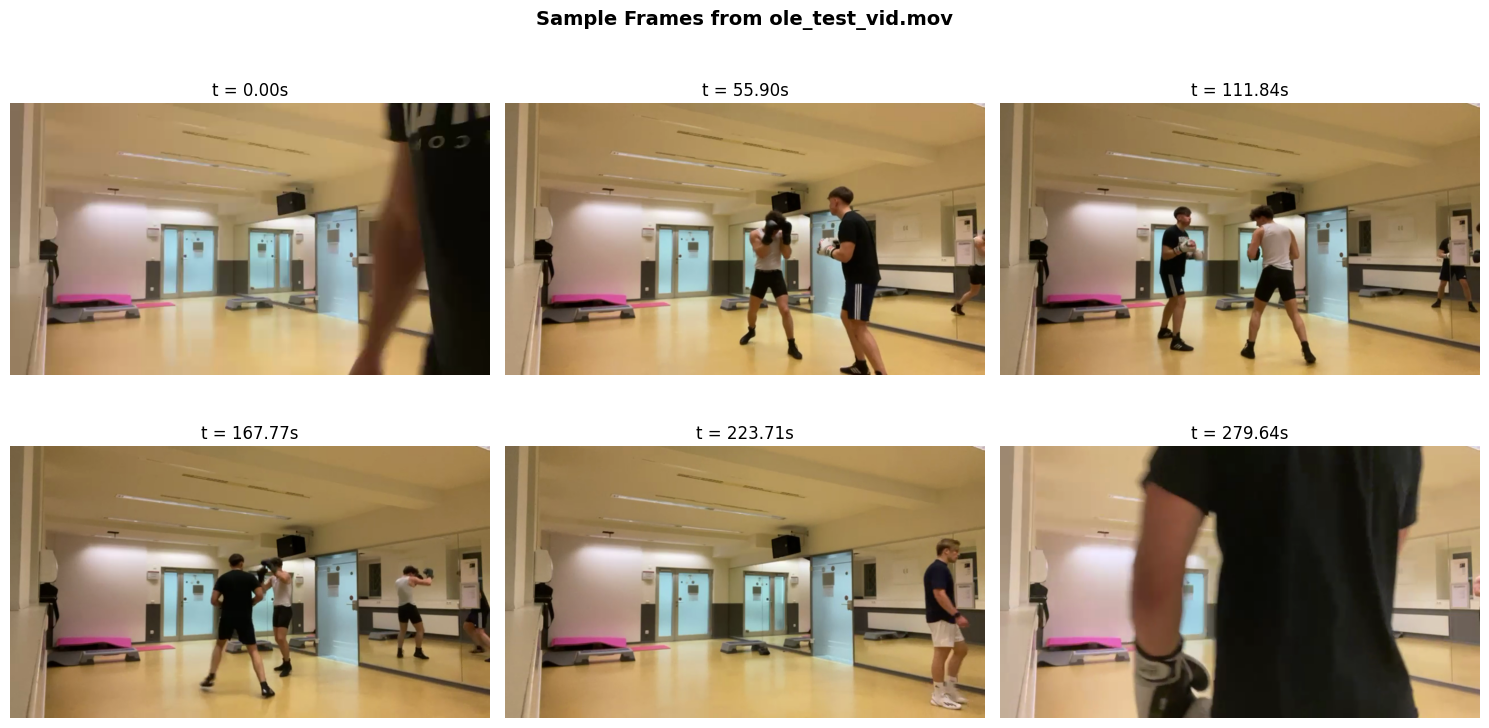

In [10]:
def extract_sample_frames(video_path: str, num_frames: int = 6) -> tuple[list, list]:
    """Extract evenly spaced frames from a video for visualization."""
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {video_path}")
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Calculate frame indices to sample evenly across the video
    indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    
    frames = []
    timestamps = []
    
    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            # Convert BGR to RGB for matplotlib
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)
            timestamps.append(idx / fps)
    
    cap.release()
    return frames, timestamps


def display_frame_grid(frames: list, timestamps: list, title: str = "Sample Frames") -> None:
    """Display frames in a grid layout."""
    n_frames = len(frames)
    cols = min(3, n_frames)
    rows = (n_frames + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle(title, fontsize=14, fontweight='bold')
    
    for i, (frame, ts) in enumerate(zip(frames, timestamps)):
        row, col = i // cols, i % cols
        axes[row, col].imshow(frame)
        axes[row, col].set_title(f"t = {ts:.2f}s")
        axes[row, col].axis('off')
    
    # Hide empty subplots
    for i in range(len(frames), rows * cols):
        row, col = i // cols, i % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()


# Extract and display sample frames from the video
print("\nExtracting sample frames...")
frames, timestamps = extract_sample_frames(VIDEO_PATH, num_frames=6)
print(f"Extracted {len(frames)} frames")
display_frame_grid(frames, timestamps, title="Sample Frames from ole_test_vid.mov")

Model downloaded successfully!


I0000 00:00:1769073781.893741 1085194 gl_context.cc:407] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M4
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1769073781.932543 1085197 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769073781.937701 1085199 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769073781.962028 1085197 landmark_projection_calculator.cc:81] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Running MediaPipe pose estimation...
Processed 6 frames


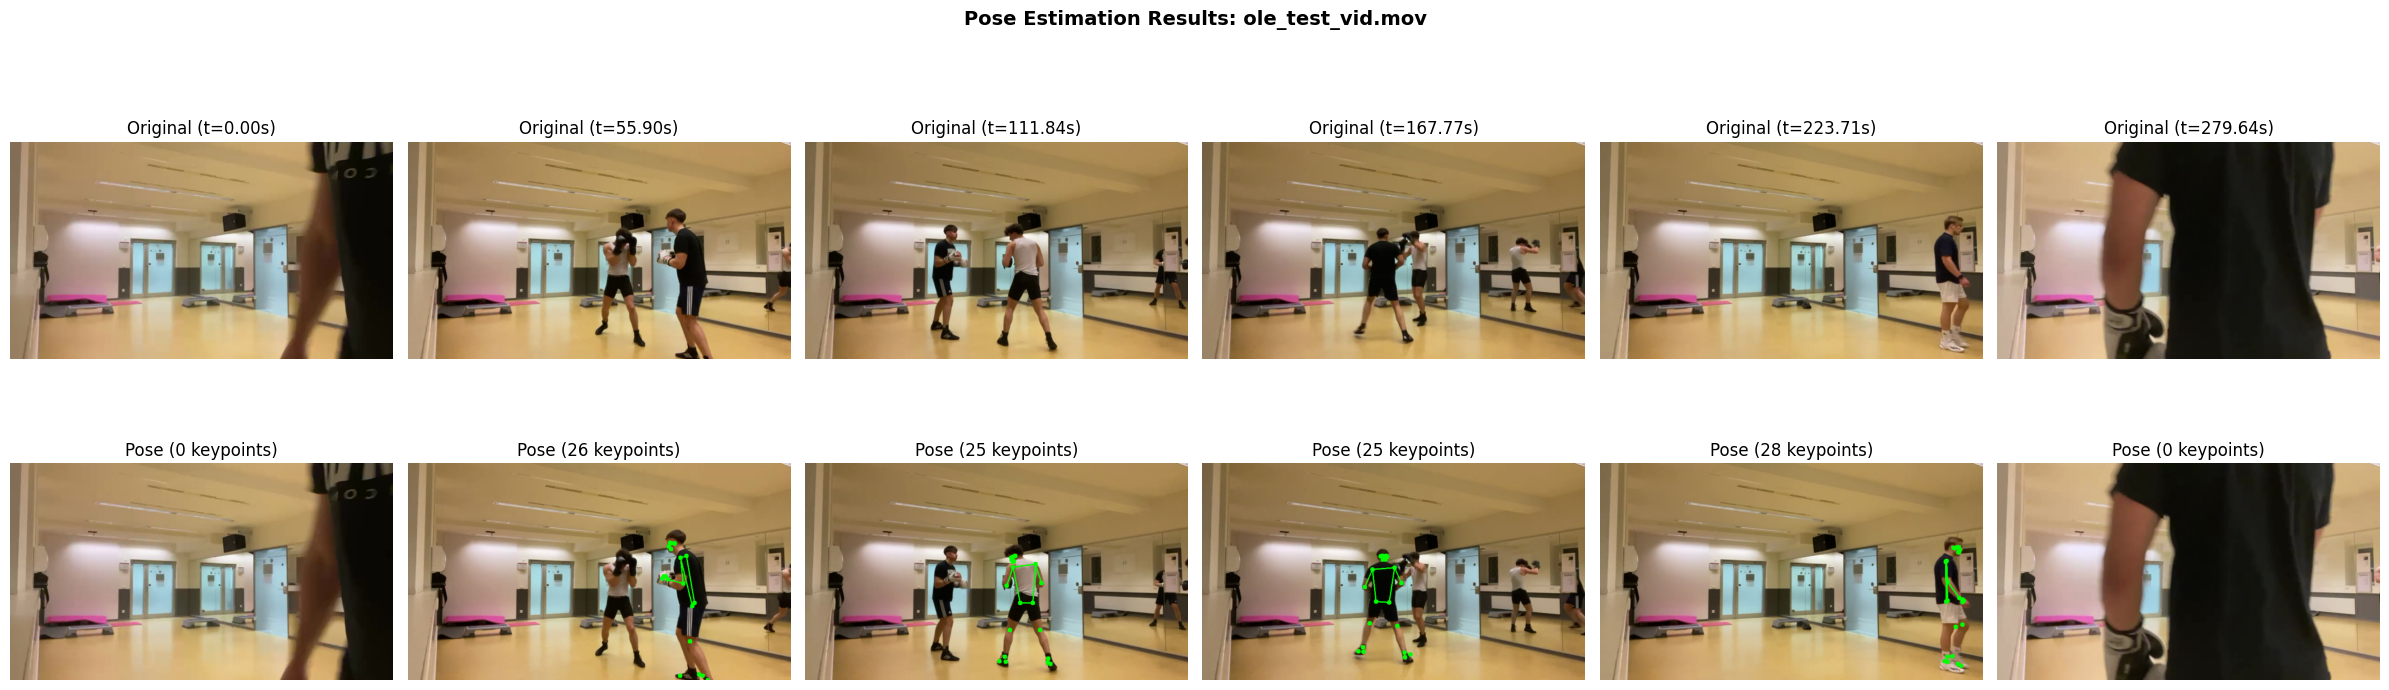

In [12]:
import mediapipe as mp
from mediapipe.tasks.python.vision import PoseLandmarker, PoseLandmarkerOptions, PoseLandmarkerResult
from mediapipe.tasks.python.core import base_options
from mediapipe.tasks.python.vision.core import vision_task_running_mode
import urllib.request
import os

# Download the pose landmarker model if not already present
MODEL_PATH = "pose_landmarker.task"
if not os.path.exists(MODEL_PATH):
    print("Downloading pose landmarker model...")
    url = "https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_lite/float16/1/pose_landmarker_lite.task"
    urllib.request.urlretrieve(url, MODEL_PATH)
    print("Model downloaded successfully!")

# Initialize MediaPipe Pose Landmarker
base_options_instance = base_options.BaseOptions(model_asset_path=MODEL_PATH)
options = PoseLandmarkerOptions(
    base_options=base_options_instance,
    running_mode=vision_task_running_mode.VisionTaskRunningMode.IMAGE,
    num_poses=1,
    min_pose_detection_confidence=0.5,
    min_pose_presence_confidence=0.5,
    min_tracking_confidence=0.5,
    output_segmentation_masks=False
)

pose_landmarker = PoseLandmarker.create_from_options(options)


def run_pose_estimation_on_frames(frames: list) -> list:
    """Run MediaPipe pose estimation on a list of frames."""
    results_list = []
    
    for frame in frames:
        # Convert numpy array to MediaPipe Image
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
        # Detect pose landmarks
        detection_result = pose_landmarker.detect(mp_image)
        results_list.append(detection_result)
    
    return results_list


def draw_pose_on_frame(frame: np.ndarray, result: PoseLandmarkerResult) -> np.ndarray:
    """Draw pose landmarks on a frame."""
    annotated = frame.copy()
    
    if result.pose_landmarks and len(result.pose_landmarks) > 0:
        # MediaPipe 0.10+ returns landmarks as a list of lists
        landmarks = result.pose_landmarks[0]  # Get first (and only) pose
        
        # Draw connections manually (simplified - drawing key upper body connections)
        h, w = frame.shape[:2]
        
        # Define connections for upper body (MediaPipe pose connections)
        connections = [
            (11, 12),  # left_shoulder - right_shoulder
            (11, 13),  # left_shoulder - left_elbow
            (13, 15),  # left_elbow - left_wrist
            (12, 14),  # right_shoulder - right_elbow
            (14, 16),  # right_elbow - right_wrist
            (11, 23),  # left_shoulder - left_hip
            (12, 24),  # right_shoulder - right_hip
            (23, 24),  # left_hip - right_hip
        ]
        
        # Draw landmarks as circles
        for landmark in landmarks:
            x = int(landmark.x * w)
            y = int(landmark.y * h)
            if landmark.visibility > 0.5:
                cv2.circle(annotated, (x, y), 5, (0, 255, 0), -1)
        
        # Draw connections
        for start_idx, end_idx in connections:
            if (start_idx < len(landmarks) and end_idx < len(landmarks) and
                landmarks[start_idx].visibility > 0.5 and landmarks[end_idx].visibility > 0.5):
                start_x = int(landmarks[start_idx].x * w)
                start_y = int(landmarks[start_idx].y * h)
                end_x = int(landmarks[end_idx].x * w)
                end_y = int(landmarks[end_idx].y * h)
                cv2.line(annotated, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
    
    return annotated


def display_pose_comparison(frames: list, pose_results: list, timestamps: list) -> None:
    """Display original frames alongside pose-annotated frames."""
    n_frames = len(frames)
    
    fig, axes = plt.subplots(2, n_frames, figsize=(4 * n_frames, 8))
    fig.suptitle("Pose Estimation Results: ole_test_vid.mov", fontsize=14, fontweight='bold')
    
    for i, (frame, results, ts) in enumerate(zip(frames, pose_results, timestamps)):
        # Original frame
        axes[0, i].imshow(frame)
        axes[0, i].set_title(f"Original (t={ts:.2f}s)")
        axes[0, i].axis('off')
        
        # Pose-annotated frame
        annotated = draw_pose_on_frame(frame, results)
        axes[1, i].imshow(annotated)
        
        # Count detected landmarks
        n_landmarks = 0
        if results.pose_landmarks and len(results.pose_landmarks) > 0:
            n_landmarks = len([lm for lm in results.pose_landmarks[0] if lm.visibility > 0.5])
        axes[1, i].set_title(f"Pose ({n_landmarks} keypoints)")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()


# Run pose estimation on sample frames
print("Running MediaPipe pose estimation...")
pose_results = run_pose_estimation_on_frames(frames)
print(f"Processed {len(pose_results)} frames")

# Display comparison
display_pose_comparison(frames, pose_results, timestamps)


Extracting keypoint trajectories...


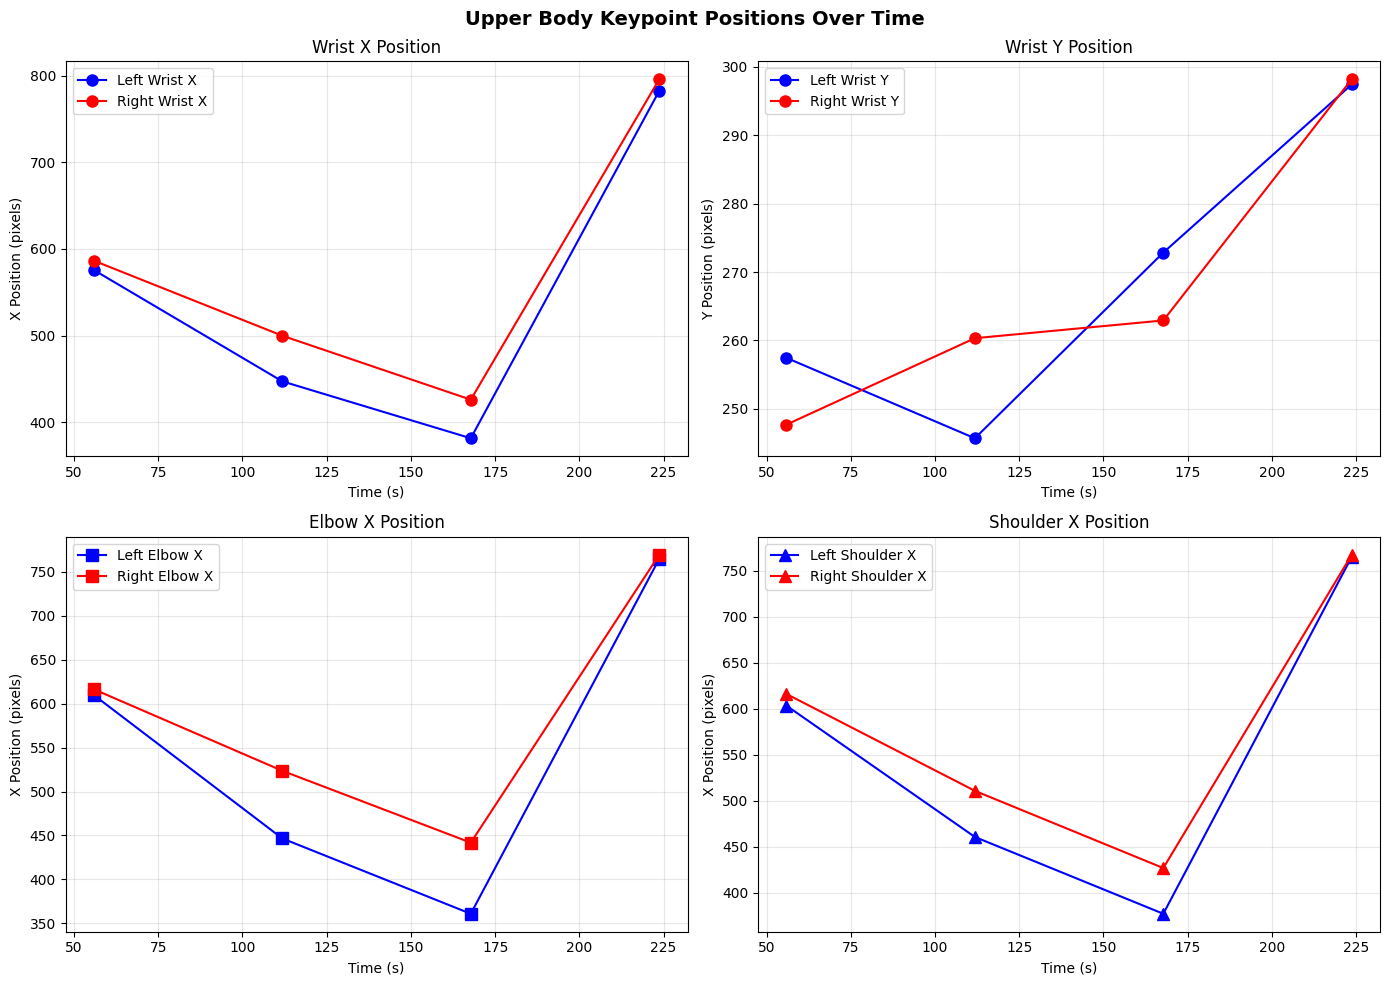

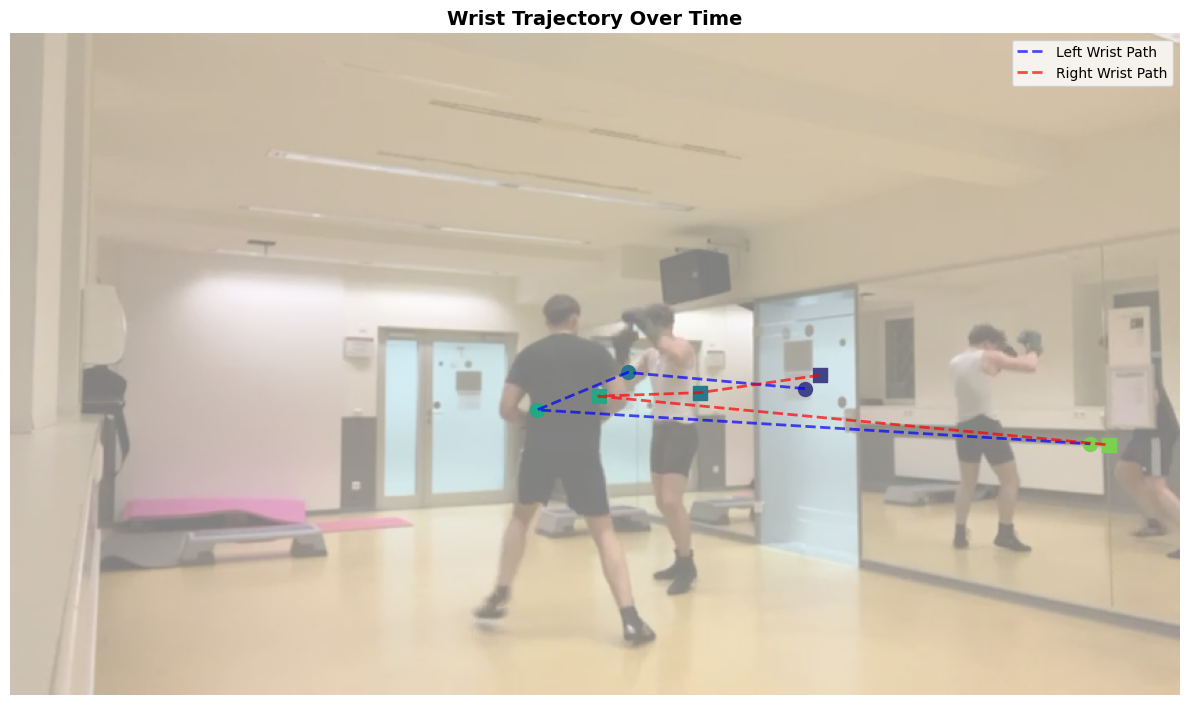


Analysis complete. The video is ready for action classification.


In [13]:
# MediaPipe landmark indices for boxing-relevant keypoints
MEDIAPIPE_LANDMARKS = {
    'left_shoulder': 11,
    'right_shoulder': 12,
    'left_elbow': 13,
    'right_elbow': 14,
    'left_wrist': 15,
    'right_wrist': 16,
    'left_hip': 23,
    'right_hip': 24,
}


def extract_keypoint_data(pose_results: list, frames: list) -> dict:
    """Extract keypoint coordinates from pose results."""
    keypoint_data = {name: {'x': [], 'y': [], 'visibility': []} 
                     for name in MEDIAPIPE_LANDMARKS}
    
    for i, results in enumerate(pose_results):
        h, w = frames[i].shape[:2]
        
        # MediaPipe 0.10+ returns pose_landmarks as a list of lists
        if results.pose_landmarks and len(results.pose_landmarks) > 0:
            landmarks = results.pose_landmarks[0]  # Get first (and only) pose
            for name, idx in MEDIAPIPE_LANDMARKS.items():
                if idx < len(landmarks):
                    lm = landmarks[idx]
                    keypoint_data[name]['x'].append(lm.x * w)
                    keypoint_data[name]['y'].append(lm.y * h)
                    keypoint_data[name]['visibility'].append(lm.visibility)
                else:
                    keypoint_data[name]['x'].append(np.nan)
                    keypoint_data[name]['y'].append(np.nan)
                    keypoint_data[name]['visibility'].append(0)
        else:
            for name in MEDIAPIPE_LANDMARKS:
                keypoint_data[name]['x'].append(np.nan)
                keypoint_data[name]['y'].append(np.nan)
                keypoint_data[name]['visibility'].append(0)
    
    return keypoint_data


def plot_keypoint_positions(keypoint_data: dict, timestamps: list) -> None:
    """Plot keypoint positions over time."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("Upper Body Keypoint Positions Over Time", fontsize=14, fontweight='bold')
    
    # Wrist positions
    ax = axes[0, 0]
    ax.plot(timestamps, keypoint_data['left_wrist']['x'], 'b-o', label='Left Wrist X', markersize=8)
    ax.plot(timestamps, keypoint_data['right_wrist']['x'], 'r-o', label='Right Wrist X', markersize=8)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('X Position (pixels)')
    ax.set_title('Wrist X Position')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax = axes[0, 1]
    ax.plot(timestamps, keypoint_data['left_wrist']['y'], 'b-o', label='Left Wrist Y', markersize=8)
    ax.plot(timestamps, keypoint_data['right_wrist']['y'], 'r-o', label='Right Wrist Y', markersize=8)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Y Position (pixels)')
    ax.set_title('Wrist Y Position')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Elbow positions
    ax = axes[1, 0]
    ax.plot(timestamps, keypoint_data['left_elbow']['x'], 'b-s', label='Left Elbow X', markersize=8)
    ax.plot(timestamps, keypoint_data['right_elbow']['x'], 'r-s', label='Right Elbow X', markersize=8)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('X Position (pixels)')
    ax.set_title('Elbow X Position')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Shoulder positions
    ax = axes[1, 1]
    ax.plot(timestamps, keypoint_data['left_shoulder']['x'], 'b-^', label='Left Shoulder X', markersize=8)
    ax.plot(timestamps, keypoint_data['right_shoulder']['x'], 'r-^', label='Right Shoulder X', markersize=8)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('X Position (pixels)')
    ax.set_title('Shoulder X Position')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_pose_trajectory_overlay(frames: list, pose_results: list, timestamps: list) -> None:
    """Overlay all pose trajectories on a single frame."""
    if not frames:
        return
    
    # Use the middle frame as background
    mid_idx = len(frames) // 2
    base_frame = frames[mid_idx].copy()
    h, w = base_frame.shape[:2]
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(base_frame, alpha=0.5)
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(frames)))
    
    for i, results in enumerate(pose_results):
        # MediaPipe 0.10+ returns pose_landmarks as a list of lists
        if results.pose_landmarks and len(results.pose_landmarks) > 0:
            landmarks = results.pose_landmarks[0]  # Get first (and only) pose
            # Draw wrist trajectories (indices 15 and 16)
            if len(landmarks) > 16:
                left_wrist = landmarks[15]
                right_wrist = landmarks[16]
                
                ax.scatter(left_wrist.x * w, left_wrist.y * h, 
                          c=[colors[i]], s=100, marker='o', label=f't={timestamps[i]:.1f}s' if i == 0 else '')
                ax.scatter(right_wrist.x * w, right_wrist.y * h, 
                          c=[colors[i]], s=100, marker='s')
    
    # Draw trajectory lines
    keypoint_data = extract_keypoint_data(pose_results, frames)
    ax.plot(keypoint_data['left_wrist']['x'], keypoint_data['left_wrist']['y'], 
            'b--', alpha=0.7, linewidth=2, label='Left Wrist Path')
    ax.plot(keypoint_data['right_wrist']['x'], keypoint_data['right_wrist']['y'], 
            'r--', alpha=0.7, linewidth=2, label='Right Wrist Path')
    
    ax.set_title('Wrist Trajectory Over Time', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()


# Extract and visualize keypoint data
print("\nExtracting keypoint trajectories...")
keypoint_data = extract_keypoint_data(pose_results, frames)

# Plot keypoint positions over time
plot_keypoint_positions(keypoint_data, timestamps)

# Plot trajectory overlay
plot_pose_trajectory_overlay(frames, pose_results, timestamps)

print("\nAnalysis complete. The video is ready for action classification.")

## 11. Video-Level Pose Extraction

To classify actions across an entire video, we need continuous pose sequences rather than sparse samples. The following extracts poses from every frame, converts MediaPipe's 33-keypoint format to COCO's 17-keypoint format for model compatibility, and packages the result as a numpy array suitable for sliding window analysis.

In [2]:
from typing import Tuple, Optional
import numpy as np
import cv2
import mediapipe as mp
from dataclasses import dataclass
from tqdm.auto import tqdm

# MediaPipe to COCO keypoint mapping. MediaPipe uses 33 landmarks; we extract
# the 17 that correspond to COCO format for model compatibility.
MEDIAPIPE_TO_COCO = {
    0: 0,   # nose
    2: 1,   # left_eye (MP left_eye_inner -> COCO left_eye)
    5: 2,   # right_eye (MP right_eye_inner -> COCO right_eye)
    7: 3,   # left_ear
    8: 4,   # right_ear
    11: 5,  # left_shoulder
    12: 6,  # right_shoulder
    13: 7,  # left_elbow
    14: 8,  # right_elbow
    15: 9,  # left_wrist
    16: 10, # right_wrist
    23: 11, # left_hip
    24: 12, # right_hip
    25: 13, # left_knee
    26: 14, # right_knee
    27: 15, # left_ankle
    28: 16, # right_ankle
}


@dataclass
class VideoKeypoints:
    """Container for extracted pose data from a video."""
    keypoints: np.ndarray      # shape: (T, 17, 2) - normalized coordinates
    confidence: np.ndarray     # shape: (T, 17) - per-keypoint confidence
    timestamps: np.ndarray     # shape: (T,) - frame timestamps in seconds
    fps: float
    video_path: str
    
    def __len__(self) -> int:
        return len(self.timestamps)
    
    @property
    def duration(self) -> float:
        return self.timestamps[-1] - self.timestamps[0] if len(self.timestamps) > 1 else 0.0


def extract_video_keypoints(
    video_path: str,
    start_time: Optional[float] = None,
    end_time: Optional[float] = None,
    subsample: int = 1,
    min_detection_confidence: float = 0.5,
    min_tracking_confidence: float = 0.5,
    show_progress: bool = True
) -> VideoKeypoints:
    """
    Extracts pose keypoints from every frame of a video.
    
    Args:
        video_path: Path to video file
        start_time: Start extraction at this time (seconds). None = beginning.
        end_time: Stop extraction at this time (seconds). None = end.
        subsample: Process every Nth frame (1 = all frames, 2 = half, etc.)
        min_detection_confidence: MediaPipe detection threshold
        min_tracking_confidence: MediaPipe tracking threshold
        show_progress: Display progress bar
        
    Returns:
        VideoKeypoints containing pose sequences for the entire video
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {video_path}")
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate frame range
    start_frame = int(start_time * fps) if start_time else 0
    end_frame = int(end_time * fps) if end_time else total_frames
    end_frame = min(end_frame, total_frames)
    
    # Seek to start
    if start_frame > 0:
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    # Initialize MediaPipe
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(
        static_image_mode=False,
        model_complexity=1,
        min_detection_confidence=min_detection_confidence,
        min_tracking_confidence=min_tracking_confidence
    )
    
    keypoints_list = []
    confidence_list = []
    timestamps_list = []
    
    frame_idx = start_frame
    frames_to_process = range(start_frame, end_frame, subsample)
    
    iterator = tqdm(frames_to_process, desc="Extracting poses") if show_progress else frames_to_process
    
    try:
        for target_frame in iterator:
            # Skip to target frame if subsampling
            while frame_idx < target_frame:
                cap.grab()
                frame_idx += 1
            
            ret, frame = cap.read()
            if not ret:
                break
            frame_idx += 1
            
            # Convert BGR to RGB for MediaPipe
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(rgb_frame)
            
            # Extract keypoints in COCO format
            kp = np.zeros((17, 2), dtype=np.float32)
            conf = np.zeros(17, dtype=np.float32)
            
            if results.pose_landmarks:
                landmarks = results.pose_landmarks.landmark
                for mp_idx, coco_idx in MEDIAPIPE_TO_COCO.items():
                    if mp_idx < len(landmarks):
                        lm = landmarks[mp_idx]
                        kp[coco_idx] = [lm.x, lm.y]
                        conf[coco_idx] = lm.visibility
            
            keypoints_list.append(kp)
            confidence_list.append(conf)
            timestamps_list.append(target_frame / fps)
    
    finally:
        cap.release()
        pose.close()
    
    effective_fps = fps / subsample
    
    return VideoKeypoints(
        keypoints=np.array(keypoints_list),
        confidence=np.array(confidence_list),
        timestamps=np.array(timestamps_list),
        fps=effective_fps,
        video_path=video_path
    )


def save_keypoints(vk: VideoKeypoints, path: str) -> None:
    """Saves extracted keypoints to a compressed numpy file."""
    np.savez_compressed(
        path,
        keypoints=vk.keypoints,
        confidence=vk.confidence,
        timestamps=vk.timestamps,
        fps=vk.fps,
        video_path=vk.video_path
    )
    print(f"Saved keypoints to {path}")


def load_keypoints(path: str) -> VideoKeypoints:
    """Loads keypoints from a saved numpy file."""
    data = np.load(path, allow_pickle=True)
    return VideoKeypoints(
        keypoints=data['keypoints'],
        confidence=data['confidence'],
        timestamps=data['timestamps'],
        fps=float(data['fps']),
        video_path=str(data['video_path'])
    )

ModuleNotFoundError: No module named 'tqdm'

## 12. Sliding Window Action Detection

A trained classifier expects fixed-length sequences representing single actions. To detect actions in continuous video, we slide a window across the pose sequence, classify each window, and aggregate predictions. Overlapping windows with temporal smoothing reduce false positives from transient poses.

The window size matches our training clip length (45 frames at 30fps ≈ 1.5 seconds). We stride by half the window width to balance temporal resolution against computational cost.

In [ ]:
from typing import List, Dict
import torch
import torch.nn.functional as F


@dataclass
class ActionPrediction:
    """A single action prediction with temporal bounds and confidence."""
    action: int
    action_name: str
    start_time: float
    end_time: float
    confidence: float
    raw_logits: np.ndarray


@dataclass  
class VideoAnalysis:
    """Complete action analysis results for a video."""
    predictions: List[ActionPrediction]
    frame_probs: np.ndarray      # shape: (T, num_classes) per-frame probabilities
    frame_timestamps: np.ndarray  # shape: (T,) timestamps for frame_probs
    action_counts: Dict[str, int]
    video_path: str


def sliding_window_inference(
    model: nn.Module,
    keypoints: VideoKeypoints,
    window_size: int = 45,
    stride: int = 15,
    device: torch.device = None,
    confidence_threshold: float = 0.5
) -> VideoAnalysis:
    """
    Runs action classification across a video using overlapping sliding windows.
    
    Args:
        model: Trained BoxingActionClassifier
        keypoints: Extracted pose data from video
        window_size: Number of frames per classification window
        stride: Step size between consecutive windows
        device: Compute device (auto-detected if None)
        confidence_threshold: Minimum confidence to report a prediction
        
    Returns:
        VideoAnalysis with per-frame probabilities and detected actions
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = model.to(device)
    model.eval()
    
    # Normalize keypoints
    kp_normalized = normalize_pose(keypoints.keypoints)
    T = len(kp_normalized)
    
    if T < window_size:
        raise ValueError(f"Video too short ({T} frames) for window size {window_size}")
    
    # Generate windows
    window_starts = list(range(0, T - window_size + 1, stride))
    
    # Batch inference for efficiency
    windows = []
    for start in window_starts:
        window = kp_normalized[start:start + window_size]
        windows.append(window)
    
    windows_tensor = torch.FloatTensor(np.array(windows)).to(device)
    
    with torch.no_grad():
        logits = model(windows_tensor)
        probs = F.softmax(logits, dim=-1).cpu().numpy()
    
    # Interpolate to per-frame probabilities
    # Each frame gets the average probability from all windows containing it
    frame_probs = np.zeros((T, probs.shape[1]), dtype=np.float32)
    frame_counts = np.zeros(T, dtype=np.float32)
    
    for i, start in enumerate(window_starts):
        frame_probs[start:start + window_size] += probs[i]
        frame_counts[start:start + window_size] += 1
    
    # Avoid division by zero at edges
    frame_counts = np.maximum(frame_counts, 1)
    frame_probs /= frame_counts[:, np.newaxis]
    
    # Extract discrete predictions with temporal smoothing
    predictions = _extract_action_segments(
        frame_probs, 
        keypoints.timestamps,
        confidence_threshold
    )
    
    # Count actions
    action_counts = {}
    for pred in predictions:
        name = pred.action_name
        action_counts[name] = action_counts.get(name, 0) + 1
    
    return VideoAnalysis(
        predictions=predictions,
        frame_probs=frame_probs,
        frame_timestamps=keypoints.timestamps,
        action_counts=action_counts,
        video_path=keypoints.video_path
    )


def _extract_action_segments(
    frame_probs: np.ndarray,
    timestamps: np.ndarray,
    confidence_threshold: float,
    min_segment_frames: int = 5,
    idle_class: int = 12
) -> List[ActionPrediction]:
    """
    Extracts discrete action segments from per-frame probabilities.
    
    Uses argmax classification with segment merging: consecutive frames with
    the same predicted class are grouped, and short segments are filtered.
    """
    predictions = []
    
    # Get per-frame predictions
    frame_classes = frame_probs.argmax(axis=1)
    frame_confidence = frame_probs.max(axis=1)
    
    # Segment by class transitions
    i = 0
    while i < len(frame_classes):
        current_class = frame_classes[i]
        start_idx = i
        
        # Find end of segment
        while i < len(frame_classes) and frame_classes[i] == current_class:
            i += 1
        
        end_idx = i
        segment_len = end_idx - start_idx
        
        # Filter: skip idle, short segments, low confidence
        if current_class == idle_class:
            continue
        if segment_len < min_segment_frames:
            continue
        
        avg_confidence = frame_confidence[start_idx:end_idx].mean()
        if avg_confidence < confidence_threshold:
            continue
        
        predictions.append(ActionPrediction(
            action=int(current_class),
            action_name=ACTION_LABELS[int(current_class)],
            start_time=float(timestamps[start_idx]),
            end_time=float(timestamps[min(end_idx, len(timestamps) - 1)]),
            confidence=float(avg_confidence),
            raw_logits=frame_probs[start_idx:end_idx].mean(axis=0)
        ))
    
    return predictions

## 13. Classification Results Visualization

The following functions visualize action detection results: a timeline showing when each action occurs, probability heatmaps over time, and summary statistics for tactical analysis.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap

# Color scheme for action types (grouped by trajectory)
ACTION_COLORS = {
    0: '#1f77b4',   # Jab Head - blue
    1: '#aec7e8',   # Jab Body - light blue
    2: '#ff7f0e',   # Cross Head - orange
    3: '#ffbb78',   # Cross Body - light orange
    4: '#2ca02c',   # Lead Hook Head - green
    5: '#98df8a',   # Lead Hook Body - light green
    6: '#d62728',   # Rear Hook Head - red
    7: '#ff9896',   # Rear Hook Body - light red
    8: '#9467bd',   # Lead Uppercut - purple
    9: '#c5b0d5',   # Rear Uppercut - light purple
    10: '#8c564b',  # Overhand - brown
    11: '#7f7f7f',  # Defensive - gray
    12: '#c7c7c7',  # Idle - light gray
}


def plot_action_timeline(
    analysis: VideoAnalysis,
    figsize: Tuple[int, int] = (14, 4),
    title: Optional[str] = None
) -> plt.Figure:
    """
    Creates a timeline visualization showing detected actions over video duration.
    
    Each action appears as a colored bar on the timeline, with color indicating
    action type and vertical position grouping similar actions together.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Group actions by trajectory type for vertical positioning
    trajectory_groups = {
        'straight': [0, 1, 2, 3],
        'hook': [4, 5, 6, 7],
        'uppercut': [8, 9],
        'other': [10, 11]
    }
    
    group_y = {'straight': 3, 'hook': 2, 'uppercut': 1, 'other': 0}
    
    def get_group(action_id: int) -> str:
        for group, actions in trajectory_groups.items():
            if action_id in actions:
                return group
        return 'other'
    
    # Plot each prediction as a horizontal bar
    for pred in analysis.predictions:
        group = get_group(pred.action)
        y = group_y[group]
        width = pred.end_time - pred.start_time
        
        rect = mpatches.FancyBboxPatch(
            (pred.start_time, y - 0.35),
            width, 0.7,
            boxstyle="round,pad=0.02",
            facecolor=ACTION_COLORS[pred.action],
            edgecolor='black',
            linewidth=0.5,
            alpha=0.7 + 0.3 * pred.confidence  # Higher confidence = more opaque
        )
        ax.add_patch(rect)
    
    # Format axes
    duration = analysis.frame_timestamps[-1]
    ax.set_xlim(0, duration)
    ax.set_ylim(-0.5, 3.5)
    ax.set_yticks([0, 1, 2, 3])
    ax.set_yticklabels(['Other', 'Uppercuts', 'Hooks', 'Straights'])
    ax.set_xlabel('Time (seconds)')
    
    if title:
        ax.set_title(title, fontweight='bold')
    else:
        ax.set_title('Detected Boxing Actions Timeline', fontweight='bold')
    
    # Create legend
    legend_handles = []
    for action_id, name in ACTION_LABELS.items():
        if action_id != 12:  # Skip idle
            patch = mpatches.Patch(color=ACTION_COLORS[action_id], label=name)
            legend_handles.append(patch)
    
    ax.legend(handles=legend_handles, loc='upper right', ncol=3, fontsize=8)
    
    plt.tight_layout()
    return fig


def plot_probability_heatmap(
    analysis: VideoAnalysis,
    figsize: Tuple[int, int] = (14, 6),
    exclude_idle: bool = True
) -> plt.Figure:
    """
    Creates a heatmap showing classification probabilities over time.
    
    Each row is an action class, each column is a time point, and color
    intensity indicates prediction confidence for that class at that time.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    probs = analysis.frame_probs.T  # (classes, time)
    
    if exclude_idle:
        probs = probs[:-1]  # Remove idle class
        labels = [ACTION_LABELS[i] for i in range(12)]
    else:
        labels = list(ACTION_LABELS.values())
    
    # Subsample for visualization if too many frames
    max_cols = 500
    if probs.shape[1] > max_cols:
        step = probs.shape[1] // max_cols
        probs = probs[:, ::step]
        times = analysis.frame_timestamps[::step]
    else:
        times = analysis.frame_timestamps
    
    im = ax.imshow(probs, aspect='auto', cmap='YlOrRd', vmin=0, vmax=1)
    
    # Format axes
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels, fontsize=9)
    
    # X-axis: show time in seconds
    n_ticks = 10
    tick_positions = np.linspace(0, len(times) - 1, n_ticks, dtype=int)
    tick_labels = [f"{times[i]:.1f}s" for i in tick_positions]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    ax.set_xlabel('Time')
    
    ax.set_title('Action Classification Probabilities Over Time', fontweight='bold')
    
    plt.colorbar(im, ax=ax, label='Probability')
    plt.tight_layout()
    return fig


def plot_action_statistics(
    analysis: VideoAnalysis,
    figsize: Tuple[int, int] = (12, 5)
) -> plt.Figure:
    """
    Creates bar charts summarizing action counts and average confidence.
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Count by action type
    counts = {name: 0 for name in ACTION_LABELS.values()}
    confidences = {name: [] for name in ACTION_LABELS.values()}
    
    for pred in analysis.predictions:
        counts[pred.action_name] += 1
        confidences[pred.action_name].append(pred.confidence)
    
    # Filter to actions that occurred
    active_actions = [name for name, count in counts.items() if count > 0]
    active_counts = [counts[name] for name in active_actions]
    active_colors = [ACTION_COLORS[list(ACTION_LABELS.values()).index(name)] 
                     for name in active_actions]
    
    # Plot 1: Action counts
    ax1 = axes[0]
    bars = ax1.barh(range(len(active_actions)), active_counts, color=active_colors)
    ax1.set_yticks(range(len(active_actions)))
    ax1.set_yticklabels(active_actions)
    ax1.set_xlabel('Count')
    ax1.set_title('Action Frequency', fontweight='bold')
    
    # Add count labels
    for bar, count in zip(bars, active_counts):
        ax1.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
                 str(count), va='center', fontsize=9)
    
    # Plot 2: Average confidence per action type
    ax2 = axes[1]
    avg_conf = [np.mean(confidences[name]) if confidences[name] else 0 
                for name in active_actions]
    
    bars2 = ax2.barh(range(len(active_actions)), avg_conf, color=active_colors)
    ax2.set_yticks(range(len(active_actions)))
    ax2.set_yticklabels(active_actions)
    ax2.set_xlabel('Average Confidence')
    ax2.set_xlim(0, 1)
    ax2.set_title('Classification Confidence', fontweight='bold')
    
    plt.tight_layout()
    return fig


def print_analysis_summary(analysis: VideoAnalysis) -> None:
    """Prints a text summary of the video analysis results."""
    duration = analysis.frame_timestamps[-1] - analysis.frame_timestamps[0]
    total_actions = len(analysis.predictions)
    
    print("=" * 60)
    print("Boxing Action Analysis Summary")
    print("=" * 60)
    print(f"Video: {Path(analysis.video_path).name}")
    print(f"Duration analyzed: {duration:.1f} seconds")
    print(f"Total actions detected: {total_actions}")
    print(f"Actions per minute: {total_actions / (duration / 60):.1f}")
    print()
    
    if analysis.action_counts:
        print("Action breakdown:")
        for name, count in sorted(analysis.action_counts.items(), 
                                   key=lambda x: x[1], reverse=True):
            pct = 100 * count / total_actions
            print(f"  {name}: {count} ({pct:.1f}%)")
    print("=" * 60)

## 14. Running Action Classification

With all components in place, we can now run the complete analysis pipeline on the test video. Note that this requires a trained model. The cells below demonstrate the workflow; for actual classification, load trained weights first.

In [ ]:
def run_full_analysis(
    video_path: str,
    model: nn.Module = None,
    window_size: int = 45,
    stride: int = 15,
    subsample: int = 1,
    start_time: float = None,
    end_time: float = None,
    keypoints_cache_path: str = None,
    confidence_threshold: float = 0.5
) -> VideoAnalysis:
    """
    Runs the complete action analysis pipeline on a video.
    
    Args:
        video_path: Path to input video
        model: Trained BoxingActionClassifier (if None, uses random weights for demo)
        window_size: Classification window size in frames
        stride: Window stride for sliding window inference
        subsample: Frame subsampling rate for pose extraction
        start_time: Start analysis at this time (seconds)
        end_time: End analysis at this time (seconds)
        keypoints_cache_path: Path to save/load extracted keypoints
        confidence_threshold: Minimum confidence for reported predictions
        
    Returns:
        VideoAnalysis with complete results
    """
    # Step 1: Extract or load keypoints
    if keypoints_cache_path and os.path.exists(keypoints_cache_path):
        print(f"Loading cached keypoints from {keypoints_cache_path}")
        keypoints = load_keypoints(keypoints_cache_path)
    else:
        print("Extracting pose keypoints from video...")
        keypoints = extract_video_keypoints(
            video_path,
            start_time=start_time,
            end_time=end_time,
            subsample=subsample
        )
        if keypoints_cache_path:
            save_keypoints(keypoints, keypoints_cache_path)
    
    print(f"Extracted {len(keypoints)} frames ({keypoints.duration:.1f}s)")
    
    # Step 2: Initialize model if not provided
    if model is None:
        print("\nWARNING: No trained model provided. Using random weights for demonstration.")
        print("Classification results will not be meaningful until model is trained.\n")
        model = BoxingActionClassifier()
    
    # Step 3: Run sliding window classification
    print("Running action classification...")
    analysis = sliding_window_inference(
        model=model,
        keypoints=keypoints,
        window_size=window_size,
        stride=stride,
        confidence_threshold=confidence_threshold
    )
    
    return analysis

In [ ]:
# Run analysis on the test video (first 30 seconds for demonstration)
# Note: Without a trained model, classifications will be random

analysis = run_full_analysis(
    VIDEO_PATH,
    model=None,  # Replace with trained model for real results
    start_time=0,
    end_time=30,  # Analyze first 30 seconds
    keypoints_cache_path="ole_test_keypoints.npz"
)

print_analysis_summary(analysis)

In [ ]:
# Visualize results
plot_action_timeline(analysis, title="Boxing Actions: ole_test_vid.mov (0-30s)")
plt.show()

plot_probability_heatmap(analysis)
plt.show()

plot_action_statistics(analysis)
plt.show()

## 15. Preparing Training Data

Before training the classifier, labeled pose sequences are needed. The workflow is:
1. Extract keypoints from tutorial/demonstration videos
2. Use the labeling interface (keyboard hotkeys) to annotate action clips
3. Build train/validation splits
4. Train the TCN classifier

The following provides utilities for creating training datasets from labeled clips.

In [ ]:
from sklearn.model_selection import train_test_split


@dataclass
class LabeledClip:
    """A labeled pose sequence for training."""
    keypoints: np.ndarray  # shape: (T, 17, 2)
    label: int
    source_video: str
    start_time: float
    end_time: float


def create_training_dataset(
    labeled_clips: List[LabeledClip],
    val_fraction: float = 0.2,
    target_length: int = 45,
    random_seed: int = 42
) -> Tuple[PoseSequenceDataset, PoseSequenceDataset]:
    """
    Creates train and validation datasets from labeled clips.
    
    Args:
        labeled_clips: List of LabeledClip instances
        val_fraction: Fraction of data to use for validation
        target_length: Sequence length for the model
        random_seed: Random seed for reproducible splits
        
    Returns:
        (train_dataset, val_dataset) tuple
    """
    # Normalize all sequences
    sequences = [normalize_pose(clip.keypoints) for clip in labeled_clips]
    labels = [clip.label for clip in labeled_clips]
    
    # Stratified split to maintain class balance
    train_seq, val_seq, train_labels, val_labels = train_test_split(
        sequences, labels,
        test_size=val_fraction,
        random_state=random_seed,
        stratify=labels
    )
    
    train_dataset = PoseSequenceDataset(
        train_seq, train_labels,
        target_length=target_length,
        augment=True
    )
    
    val_dataset = PoseSequenceDataset(
        val_seq, val_labels,
        target_length=target_length,
        augment=False
    )
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Classes represented: {len(set(labels))}")
    
    return train_dataset, val_dataset


def train_model(
    model: nn.Module,
    train_dataset: PoseSequenceDataset,
    val_dataset: PoseSequenceDataset,
    epochs: int = 100,
    batch_size: int = 32,
    learning_rate: float = 1e-3,
    patience: int = 10,
    device: torch.device = None
) -> Dict[str, List[float]]:
    """
    Trains the boxing action classifier with early stopping.
    
    Args:
        model: BoxingActionClassifier instance
        train_dataset: Training data
        val_dataset: Validation data
        epochs: Maximum training epochs
        batch_size: Batch size
        learning_rate: Initial learning rate
        patience: Early stopping patience
        device: Compute device
        
    Returns:
        Dictionary of training history (train_loss, val_loss, train_acc, val_acc)
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = model.to(device)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1:3d} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.3f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_boxing_classifier.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break
    
    model.load_state_dict(torch.load('best_boxing_classifier.pt'))
    print(f"\nTraining complete. Best validation loss: {best_val_loss:.4f}")
    
    return history


def plot_training_history(history: Dict[str, List[float]]) -> plt.Figure:
    """Plots training and validation loss/accuracy curves."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss plot
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train')
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Validation')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss', fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy plot
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train')
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training Accuracy', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

## 16. Next Steps

The pipeline is now complete from video input to action classification output. To achieve meaningful results:

**Immediate priorities:**
1. **Collect labeled data**: Use boxing tutorial videos where instructors call out punch names
2. **Label 30-50 clips per class**: Use the hotkey interface for rapid annotation
3. **Train the classifier**: Run `train_model()` with the labeled dataset
4. **Evaluate on held-out videos**: Test generalization to new footage

**Improvements to consider:**
- **Confidence calibration**: Current softmax outputs may be overconfident
- **Temporal smoothing**: Apply HMM or CRF for more coherent action sequences
- **Multi-person tracking**: Handle videos with multiple boxers
- **3D pose lifting**: Upgrade from 2D poses for better view invariance

**Potential extensions:**
- Punch velocity estimation from wrist trajectory derivatives
- Combination detection (e.g., jab-cross sequences)
- Stance classification (orthodox vs southpaw)
- Fatigue indicators from punch frequency decay

---

## Appendix A: Alternative Approaches

This section documents approaches we evaluated but did not select.

### A.1 Synthetic Data Generation

We considered generating training data by rendering synthetic humans using the SMPL body model with programmed boxing animations. Libraries like SURREAL [7] demonstrate this approach for learning from synthetic humans. We rejected this path because the domain gap between synthetic and real video causes significant accuracy degradation, typically 15 to 30 percent, and existing motion capture databases lack the fine-grained boxing motions our taxonomy requires.

### A.2 RGB-Based Action Recognition

End-to-end models like SlowFast [8] and TimeSformer [9] operate directly on RGB frames without explicit pose extraction. We rejected this path because RGB methods require substantially more training data for comparable accuracy, lack interpretability about what features drive predictions, and generalize less well across visual domains with different lighting and backgrounds.

### A.3 Hierarchical Reasoning Models

HRM architectures excel at symbolic constraint satisfaction problems like Sudoku. Action recognition is fundamentally different: the input is continuous and high-dimensional, and the task is pattern matching rather than logical inference. There is no backtracking search over hypotheses; there is just spatiotemporal feature extraction.

### A.4 Graph Neural Networks

Skeleton-graph convolution networks like ST-GCN [2] and MS-G3D [5] model the skeleton as a graph and apply graph convolutions. This approach is more powerful than our TCN but also more complex to implement. For a 13-class problem with clear biomechanical distinctions, the simpler architecture suffices. If accuracy plateaus below our target, upgrading to graph convolutions would be the natural next step.

### A.5 Force Estimation

We do not attempt to estimate punch force from video. Force equals mass times acceleration, and monocular video cannot provide mass of the limb or deceleration at impact. What we can estimate is velocity and extension, which serve as proxies for power without claiming to measure force itself.

## Appendix B: Environment Setup

The pipeline requires PyTorch for model training, MediaPipe for pose estimation, OpenCV for video and image processing, and matplotlib for visualization. All dependencies are Python packages with no external system requirements.

For local development with uv:

```bash
uv sync
uv run jupyter notebook src/project_fight_club.ipynb
```

For Google Colab or pip-based environments:

```bash
pip install torch torchvision
pip install mediapipe
pip install opencv-python-headless
pip install matplotlib
```

For higher-accuracy pose estimation with ViTPose, which requires GPU:

```bash
pip install mmcv-full mmpose
```

Optional: For downloading videos from YouTube (requires yt-dlp installed separately):

```bash
pip install yt-dlp
```

## Appendix C: References

[1] Cao, Z., Hidalgo, G., Simon, T., Wei, S. E., & Sheikh, Y. (2019). OpenPose: Realtime Multi-Person 2D Pose Estimation Using Part Affinity Fields. *IEEE Transactions on Pattern Analysis and Machine Intelligence*.

[2] Yan, S., Xiong, Y., & Lin, D. (2018). Spatial Temporal Graph Convolutional Networks for Skeleton-Based Action Recognition. *AAAI Conference on Artificial Intelligence*.

[3] Xu, Y., Zhang, J., Zhang, Q., & Tao, D. (2022). ViTPose: Simple Vision Transformer Baselines for Human Pose Estimation. *NeurIPS*.

[4] Duan, H., Zhao, Y., Chen, K., Lin, D., & Dai, B. (2022). Revisiting Skeleton-based Action Recognition. *CVPR*.

[5] Liu, Z., Zhang, H., Chen, Z., Wang, Z., & Ouyang, W. (2020). Disentangling and Unifying Graph Convolutions for Skeleton-Based Action Recognition. *CVPR*.

[6] Lugaresi, C., Tang, J., Nash, H., et al. (2019). MediaPipe: A Framework for Building Perception Pipelines. *CVPR Workshop*.

[7] Varol, G., Romero, J., Martin, X., et al. (2017). Learning from Synthetic Humans. *CVPR*.

[8] Feichtenhofer, C., Fan, H., Malik, J., & He, K. (2019). SlowFast Networks for Video Recognition. *ICCV*.

[9] Bertasius, G., Wang, H., & Torresani, L. (2021). Is Space-Time Attention All You Need for Video Understanding? *ICML*.